In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

In [3]:
from sklearn.manifold import TSNE

In [4]:
from scipy.stats import wasserstein_distance

In [5]:
def plot_distr(data, col, y, bin_cnt=20, outliers_quantile=None):
    plt.figure(figsize=(8, 6))
    
    data_good = data.loc[y == 0, col]
    data_hal = data.loc[y == 1, col]

    if outliers_quantile is not None:
        data_good = data_good[data_good <= data_good.quantile(outliers_quantile)]
        data_hal = data_hal[data_hal <= data_hal.quantile(outliers_quantile)]

    _, bins = np.histogram(data[col], bins=bin_cnt)
    plt.hist(data_good, bins, alpha=0.6, color="b", label="good")
    plt.hist(data_hal, bins, alpha=0.6, color="r", label="hallucination")

    kl_div = wasserstein_distance(data_good, data_hal)

    ax = plt.gca()
    ax.set(
        xlabel="Feature value", 
        ylabel="Count", 
        title=f"Feature {col}\nWasserstein distance: {kl_div:.4f}"
    )
    ax.legend()

In [6]:
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
# with PdfPages(os.path.join(PLOTS_FOLDER, "feature_distributions.pdf")) as pdf:
#     for feature_name in X.columns:
#         plot_distr(X, feature_name, y, bin_cnt=20)
#         pdf.savefig()
#         plt.close()

In [228]:
from getpass import getpass
import mlflow

os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = getpass("Enter your DAGsHub access token: ")

mlflow.set_tracking_uri("https://dagshub.com/no-brainer/tda-mt.mlflow")

In [229]:
with mlflow.start_run():
    mlflow.log_metric("accuracy", accs.mean())

    mlflow.log_param("experiment_type", "hallucinations")
    mlflow.log_param("model_type", "svm")
    mlflow.log_param("model max_iter", 10000)
    mlflow.log_param("model reg_coef", 1.0)
    mlflow.log_param("model kernel", "rbf")

## Topological features from external model

In [8]:
def show_tsne_plot(X_tsne):
    colors = ["tab:blue", "tab:orange"]
    labels = ["good", "hallucination"]

    for i, (cls_name, clr) in enumerate(zip(labels, colors)):
        plt.scatter(
            X_tsne[y == i, 0], X_tsne[y == i, 1], 
            c=np.full((y == i).sum(), clr), 
            alpha=0.8,
            marker="p", s=50,
            label=cls_name
        )

    plt.legend()

In [9]:
labels_df = pd.read_csv("../data/wm_labels.csv", index_col=0)

In [10]:
def load_wm_external(thresh):
    feature_df = pd.read_csv(f"../data/wm_external_thresh{thresh}.tsv", sep="\t", index_col=0)
    full_data = labels_df.join(feature_df)
    del feature_df

    unique_cnts = full_data.nunique(axis=0)
    const_feats = unique_cnts[unique_cnts == 1]
    full_data.drop(const_feats.index.tolist(), axis=1, inplace=True)


    X = full_data.drop("label", axis=1).astype(float)
    y = (full_data.label == "hallucination").astype(float)

    return X, y

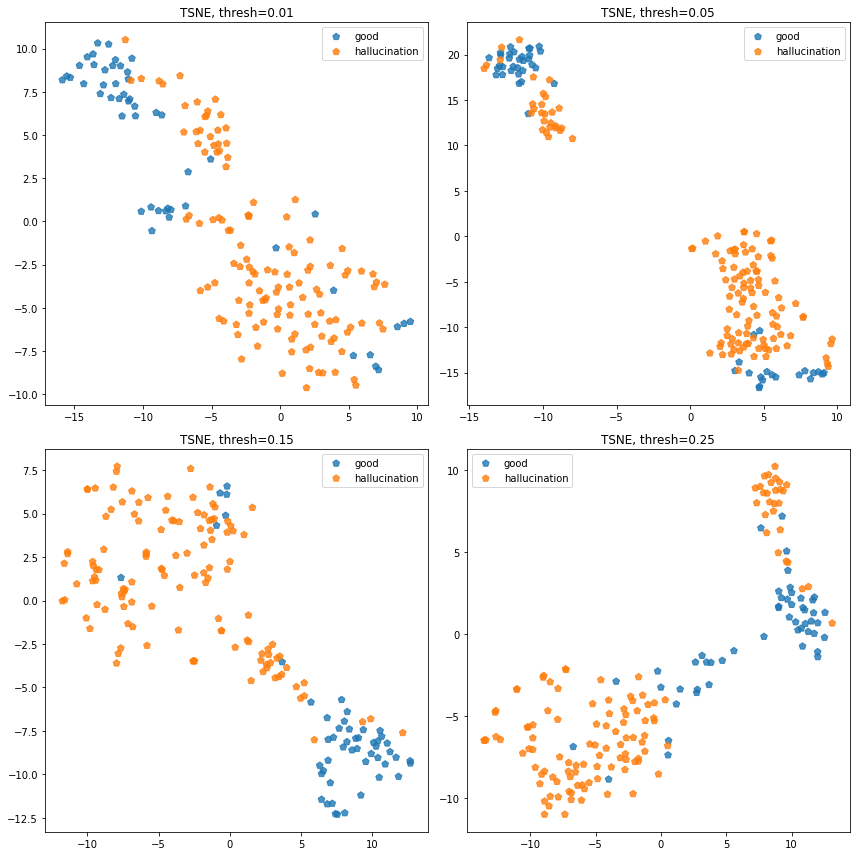

In [11]:
plt.figure(figsize=(12, 12))

for i, thresh in enumerate([0.01, 0.05, 0.15, 0.25]):
    X, y = load_wm_external(thresh)
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    plt.subplot(2, 2, i + 1)
    show_tsne_plot(X_tsne)
    plt.gca().set_title(f"TSNE, thresh={thresh}")

plt.tight_layout()

plt.show()

### Clusters in external model

In [11]:
wm_tr_df = pd.read_csv("../data/wikimatrix_translation_score.tsv", sep="\t", index_col=0)

wm_tr_df = wm_tr_df.reindex(labels_df.index)

wm_tr_df = wm_tr_df[["translation"]]

In [12]:
import os


pwd = os.getcwd()
os.chdir("../labeling/common")
from sentence_dispatcher import SentencePairDispatcher
os.chdir(pwd)

In [13]:
spd = SentencePairDispatcher("../data/WikiMatrix.en-ru.tsv")

sources = []
references = []

for idx in wm_tr_df.index:
    src, ref = spd(idx)
    sources.append(src)
    references.append(ref)

In [14]:
wm_tr_df["source"] = sources
wm_tr_df["reference"] = references

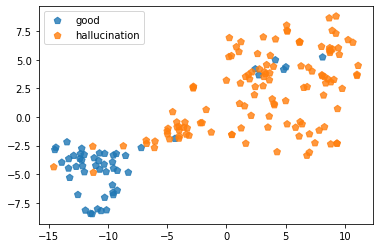

In [15]:
X, y = load_wm_external(0.15)

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

show_tsne_plot(X_tsne)

In [16]:
mask = (X_tsne[:, 0] > -5)

In [19]:
for row in wm_tr_df[~mask].sample(10).itertuples():
    print("Translation")
    print("\t", row.translation)
    print("Source")
    print("\t", row.source)
    print("\n====================\n")

Translation
	 Я больше не могу слышать Зеленое Слово.
Source
	 No longer can my ears hear the Green Word.


Translation
	 Посмотри, как мир показывает твою манеру.
Source
	 See how the world marks the manner of your bearing!


Translation
	 1999 — Какое произношение вы предпочитаете?
Source
	 1999 – Which pronunciation do you prefer?.


Translation
	 К вам явилось ясное знамение от вашего Господа.
Source
	 There has come to you clear evidence from your Lord.


Translation
	 Пусть твой Господь покончит с нами».
Source
	 Let your Lord make an end of us!'


Translation
	 Во время своего пребывания в Стинге Рой выиграл больше чем два чем чем чем два чемпионата.
Source
	 During his time with the Sting, Roy did more than win two championships.


Translation
	 Они начинают задавать свои первые вопросы о несправедливости.
Source
	 They are beginning to ask their first questions about injustice.


Translation
	 "Как слушать - маршрутная карта Индии".
Source
	 "How to Listen - a Routemap of Indi

In [21]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [26]:
clf = CatBoostClassifier(task_type="GPU", devices="1:2")

clf.fit(X_train, y_train)

Learning rate set to 0.037561
0:	learn: 0.6405718	total: 37.3ms	remaining: 37.3s
1:	learn: 0.5992871	total: 52.4ms	remaining: 26.1s
2:	learn: 0.5551024	total: 65.9ms	remaining: 21.9s
3:	learn: 0.5137866	total: 79ms	remaining: 19.7s
4:	learn: 0.4800161	total: 92.2ms	remaining: 18.3s
5:	learn: 0.4512745	total: 107ms	remaining: 17.7s
6:	learn: 0.4254997	total: 123ms	remaining: 17.4s
7:	learn: 0.3997394	total: 138ms	remaining: 17.1s
8:	learn: 0.3777060	total: 153ms	remaining: 16.8s
9:	learn: 0.3464461	total: 168ms	remaining: 16.6s
10:	learn: 0.3243969	total: 183ms	remaining: 16.5s
11:	learn: 0.3049664	total: 198ms	remaining: 16.3s
12:	learn: 0.2800273	total: 213ms	remaining: 16.1s
13:	learn: 0.2654764	total: 227ms	remaining: 16s
14:	learn: 0.2564535	total: 242ms	remaining: 15.9s
15:	learn: 0.2459543	total: 257ms	remaining: 15.8s
16:	learn: 0.2383415	total: 269ms	remaining: 15.5s
17:	learn: 0.2282182	total: 283ms	remaining: 15.4s
18:	learn: 0.2182321	total: 296ms	remaining: 15.3s
19:	learn:

In [27]:
y_pred = clf.predict(X_test)

print("Acc: {:.6f}".format((y_pred == y_test).mean()))

Acc: 0.971429


# HADES

In [36]:
import json
import linecache


def load_hades(thresh):
    X = pd.read_csv(f"../data/wikihades_thresh{thresh}.tsv", sep="\t", index_col=0)
    data_path = "../data/Wiki-Hades/train.txt"
    y = []
    for line_idx in X.index:
        line = linecache.getline(data_path, line_idx + 1)
        data = json.loads(line)
        y.append(data["hallucination"])

    y = pd.Series(data=y, index=X.index)
    return X, y

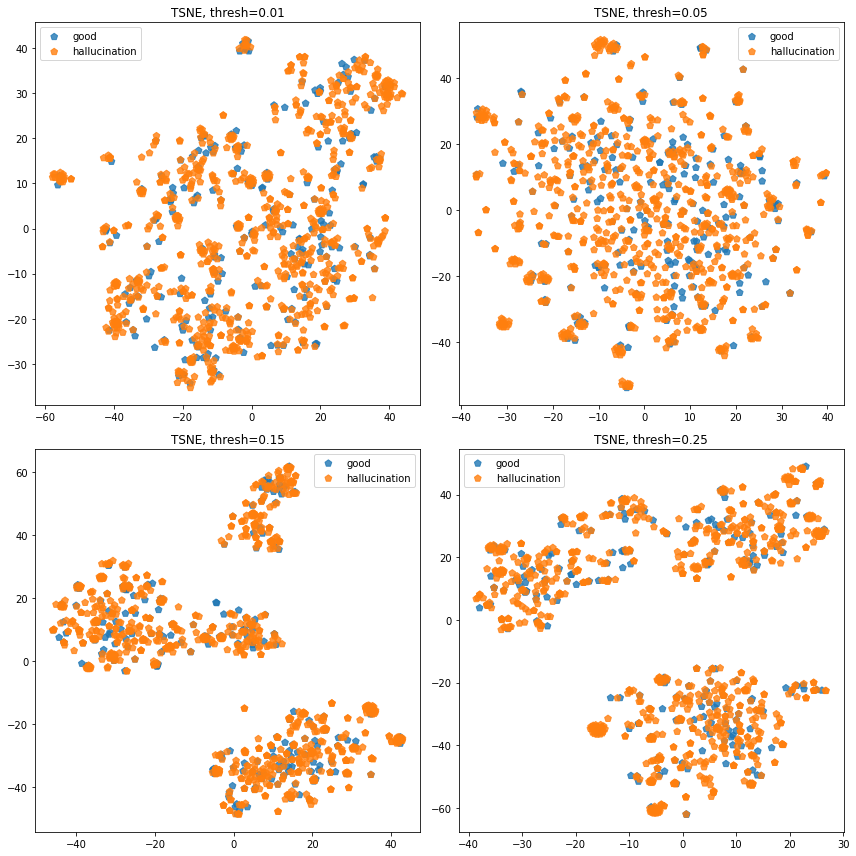

In [39]:
plt.figure(figsize=(12, 12))

for i, thresh in enumerate([0.01, 0.05, 0.15, 0.25]):
    X, y = load_hades(thresh)
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    plt.subplot(2, 2, i + 1)
    show_tsne_plot(X_tsne)
    plt.gca().set_title(f"TSNE, thresh={thresh}")

plt.tight_layout()

plt.show()

In [40]:
y.value_counts()

1    820
0    216
dtype: int64

In [41]:
X, y = load_hades(0.15)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [43]:
clf = CatBoostClassifier(task_type="GPU", devices="1:2")

clf.fit(X_train, y_train)

Learning rate set to 0.034014
0:	learn: 0.6766379	total: 20.1ms	remaining: 20.1s
1:	learn: 0.6625994	total: 38.9ms	remaining: 19.4s
2:	learn: 0.6493516	total: 57.9ms	remaining: 19.2s
3:	learn: 0.6371240	total: 77.2ms	remaining: 19.2s
4:	learn: 0.6249754	total: 96.4ms	remaining: 19.2s
5:	learn: 0.6141931	total: 115ms	remaining: 19.1s
6:	learn: 0.6035818	total: 134ms	remaining: 19s
7:	learn: 0.5941293	total: 152ms	remaining: 18.9s
8:	learn: 0.5852323	total: 170ms	remaining: 18.7s
9:	learn: 0.5775624	total: 182ms	remaining: 18s
10:	learn: 0.5693541	total: 199ms	remaining: 17.9s
11:	learn: 0.5618954	total: 217ms	remaining: 17.9s
12:	learn: 0.5558716	total: 235ms	remaining: 17.9s
13:	learn: 0.5483285	total: 253ms	remaining: 17.8s
14:	learn: 0.5423679	total: 271ms	remaining: 17.8s
15:	learn: 0.5368064	total: 288ms	remaining: 17.7s
16:	learn: 0.5318043	total: 306ms	remaining: 17.7s
17:	learn: 0.5275343	total: 323ms	remaining: 17.6s
18:	learn: 0.5219674	total: 340ms	remaining: 17.6s
19:	learn:

In [44]:
y_pred = clf.predict(X_test)

print("Acc: {:.6f}".format((y_pred == y_test).mean()))

Acc: 0.746479
